In [55]:
from matplotlib import pyplot as plt
from pathlib import Path
import mediapipe as mp
import numpy as np
from os import path
import cv2

In [56]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
PL = mp_pose.PoseLandmark

In [57]:
PROJ_DIR = Path('/Users/lyronctk/Desktop/projects/trainer')
REF_IM_DIR = PROJ_DIR / 'data/ruleset_references'
REF_PROPER = REF_IM_DIR / 'ref_proper.png'
REF_SQUAT = REF_IM_DIR / 'ref_squat.png'
REF_ROUNDED = REF_IM_DIR / 'ref_rounded.png'
REF_CROOKED = REF_IM_DIR / 'ref_crooked.png'
REF_LOCKOUT = REF_IM_DIR / 'ref_lockout.png'

# CMD to reset predictions: echo "im_path,video_id,frame_id,label" > predictions.csv
OUT_CSV = REF_IM_DIR / 'predictions.csv'

REF_PROPER_ANNOTATED = REF_IM_DIR / 'ref_proper_annotated.png'
REF_SQUAT_ANNOTATED = REF_IM_DIR / 'ref_squat_annotated.png'
REF_ROUNDED_ANNOTATED = REF_IM_DIR / 'ref_rounded_annotated.png'
REF_CROOKED_ANNOTATED = REF_IM_DIR / 'ref_crooked_annotated.png'
REF_LOCKOUT_ANNOTATED = REF_IM_DIR / 'ref_lockout_annotated.png'

In [58]:
# args
im_path = str(REF_LOCKOUT)
annotation_save_path = str(REF_LOCKOUT_ANNOTATED)
vid_id = 1
frame_id = 1
out_csv = str(OUT_CSV)

In [63]:
annotation_save_path

'/Users/lyronctk/Desktop/projects/trainer/data/ruleset_references/ref_lockout_annotated.png'

In [59]:
class BlazeSkeleton():
    def __init__(self, im_path): 
        if not path.exists(im_path):
           raise ValueError(f"{im_path} does not exist.") 
        
        blaze = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)
        self.image = cv2.imread(str(im_path))
        
        self.blaze_out = blaze.process(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
        if not self.blaze_out.pose_landmarks:
          raise ValueError(f"Pose landmarks not found for {path}.")
        self.critical_points = self.compute_critical_points(self.blaze_out)
        self.forward_vector = self.get_forward_vec()
        self.torso_size = self.compute_torso_size()
        
        self.rule_set = {
            'rounded': self.is_rounded,
            'crooked': self.is_crooked,
            'lockout': self.is_lockout,
            'squat': self.is_squat,
        }
        
    def normalize(self, v):
        norm = np.linalg.norm(v)
        return v / norm

    def midpoint(self, a, b):
        return (a + b) / 2

    def coords(self, results, landmark):
        lms = results.pose_landmarks.landmark
        return np.array([lms[landmark].x, lms[landmark].y, lms[landmark].z])
    
    def compute_critical_points(self, out):
        return {
            'knees': self.midpoint(self.coords(out, PL.LEFT_KNEE), self.coords(out, PL.LEFT_KNEE)),
            'shoulders': self.midpoint(self.coords(out, PL.LEFT_SHOULDER), self.coords(out, PL.RIGHT_SHOULDER)),
            'hips': self.midpoint(self.coords(out, PL.LEFT_HIP), self.coords(out, PL.RIGHT_HIP)),
            'hands': self.midpoint(self.coords(out, PL.LEFT_WRIST), self.coords(out, PL.RIGHT_WRIST))
        }
    
    def compute_torso_size(self):
        return np.linalg.norm(self.critical_points['shoulders'] - self.critical_points['hips'])
        
    def get_forward_vec(self):
        hips = self.critical_points['hips']
        hands = self.critical_points['hands']

        hips_xz = np.array([hips[0], hips[2]])
        hands_xz = np.array([hands[0], hands[2]])
        return self.normalize(hands_xz - hips_xz)
    
    def show_annotated(self, save_path=None):
        annotated_image = self.image.copy()
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=self.blaze_out.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_spec,
            connection_drawing_spec=drawing_spec) 
        
        rgb = annotated_image[:,:,::-1]
        fig = plt.figure()
        fig.set_size_inches(25, 10)
        plt.imshow(rgb)
        if save_path is not None:
            plt.savefig(save_path)
        
    def in_front(self, a, b, margin=0):
        # is point a in front of b?
        diff = a - b
        diff_xz = np.array([diff[0], diff[2]])
        
        # only consider x for now since z estimates are noisy
        dp = np.dot(self.forward_vector[0], diff_xz[0])
        dist = dp * self.torso_size
        return dist > margin

    def above(self, a, b, margin=True):
        # is point a above point b?
        diff_y = a[1] - b[1]
        dist = diff_y * self.torso_size
        return dist < margin
        
    def predict(self):
        for label, rule in self.rule_set.items():
            if rule():
                return label  
        return 'proper'
            
    def is_squat(self):
        return self.above(self.critical_points['knees'],
                          self.critical_points['hips'],
                          margin=0.005) 
    
    def is_rounded(self):
        # no keypoints available
        return False
    
    def is_crooked(self):
        return self.in_front(self.critical_points['hands'], 
                             self.critical_points['shoulders'],
                             margin=0.03) and not self.is_lockout()
    
    def is_lockout(self):
        return self.in_front(self.critical_points['hips'], 
                             self.critical_points['shoulders'])

prediction: lockout


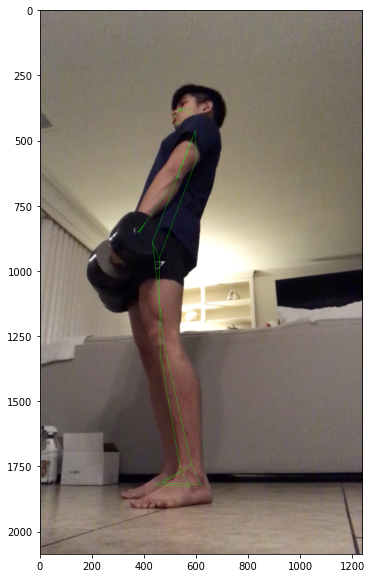

In [60]:
skel = BlazeSkeleton(im_path)
skel.show_annotated(save_path=annotation_save_path)
print(f'prediction: {skel.predict()}')

In [61]:
if out_csv is not None:
    f = open(out_csv, "a")
    f.write(f"{im_path},{vid_id},{frame_id},{skel.predict()}\n")
    f.close()